In [2]:
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

#import matplotlib.pyplot as plt

In [3]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [4]:
model_ = torch.load('PHOCNet_all_case.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])

In [5]:
# find the file names
f = open('../splits/val_files.txt', 'rb')
A = f.readlines()
f.close()
A = [x.rstrip('\n') for x in A]

In [6]:
# load test images and words
images_before = np.load('../../../detection_outputs_ready_for_test/detected_regions/'+A[0]+'.npy')
words_before = np.load('../../../detection_outputs_ready_for_test/detected_labels/'+A[0]+'.npy')

images_after = np.load('../../../detection_outputs_ready_for_test/new_regions/'+A[0]+'.npy')
words_after = np.load('../../../detection_outputs_ready_for_test/new_labels/'+A[0]+'.npy')

In [7]:
images_before = np.transpose(images_before, (0,3,1,2))
images_after = np.transpose(images_after, (0,3,1,2))
print 'images_before shape',images_before.shape
print 'words_before shape',words_before.shape
print 'images_after shape',images_after.shape
print 'words_after shape',words_after.shape

images_before shape (536, 3, 135, 487)
words_before shape (536,)
images_after shape (469, 3, 135, 487)
words_after shape (469,)


In [8]:
# convert image tnto embedding using the cnn model
def get_image_embeddings(images):
    outputs = []
    for i in tqdm(range(len(images))):
        word_img = images[i]
        word_img = 1 - word_img.astype(np.float32) / 255.0
        word_img = word_img.reshape((1,) + word_img.shape)
        word_img = torch.from_numpy(word_img).float()
        word_img = word_img.cuda(gpu_id[0])
        word_img = torch.autograd.Variable(word_img)
        output = torch.sigmoid(cnn(word_img))
        output = output.data.cpu().numpy().flatten()
        outputs.append(output)
    return outputs

outputs_before = get_image_embeddings(images_before)
outputs_after = get_image_embeddings(images_after)

100%|██████████| 469/469 [00:07<00:00, 64.17it/s]


In [9]:
# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
def create_word_variations(words):
    word_var = {}
    root_word_var = {}
    for w in words:
        if len(w) < 2:
            continue
        root_var_list = [w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            word_var[var] = 0
            word_var[var[1:]] = 1
            word_var[var[:-1]] = -1
            var_set.add(var)
            var_set.add(var[1:])
            var_set.add(var[:-1])
        root_word_var[w] = var_set
    return word_var, root_word_var

In [10]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
def get_word_phoc_representations(word_strings):
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
    bigram_levels = None
    bigrams = None
    phoc_unigram_levels=(1, 2, 4, 8)
    word_var_dir, root_word_var = create_word_variations(word_strings)
    
    word_var_strings = word_var_dir.keys()
    embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)
    
    print('embedding variations:', embedding_var.shape)
    return (embedding_var, word_var_strings, word_var_dir, root_word_var)

emb_info_before = get_word_phoc_representations(words_before)
emb_info_after = get_word_phoc_representations(words_after)
    

 31%|███       | 578/1871 [00:00<00:00, 5773.30it/s]

('embedding variations:', (1919, 945))


100%|██████████| 1871/1871 [00:00<00:00, 5979.53it/s]

('embedding variations:', (1871, 945))


In [11]:
# the new report matches method that handles variations
from scipy.spatial.distance import cdist, pdist, squareform
def report_matches_with_variations(outputs, matching, word_strings, emb_info, k, length):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var = emb_info
    # length sorting stuff
    qualified_ids = [x for x in range(len(word_strings)) if len(word_strings[x]) > length]
    outputs = np.array(outputs)
    word_strings = np.array(word_strings)
    outputs = list(outputs[qualified_ids])
    word_strings = list(word_strings[qualified_ids])
    
    # same stuff for variations
    qualified_ids_vars = [x for x in range(len(word_var_strings)) if len(word_var_strings[x]) > (length-1)]
    embedding_var = np.array(embedding_var)
    word_var_strings = np.array(word_var_strings)
    embedding_var = list(embedding_var[qualified_ids_vars])
    word_var_strings = list(word_var_strings[qualified_ids_vars])
    
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding_var, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    words_len = []
    # get all matched words
    for i in range(len(q)):
        matched = []
        for j in q[i]:
            matched.append(word_var_strings[j])
            curr_len = len(word_var_strings[j])
            curr_dir = word_var_dir[word_var_strings[j]]
            words_len.append(curr_len + abs(curr_dir))
            img_dir.append(curr_dir)
        matched_words.append(matched)
    
    # calculate accuracies
    for i in range(len(word_strings)):
        #print word_strings[i]
        if word_strings[i] in matched_words[i]:
            count = count+1
        else:
            for w in matched_words[i]:
                if w in root_word_var[word_strings[i]]:
                    count = count+1
                    break

    #q = np.squeeze(np.array(q))
    #p = np.arange(len(q))
    #print count
    return (count, matched_words, qualified_ids, img_dir, words_len, outputs, word_strings)

In [12]:
# get the matches report
match_report_before = report_matches_with_variations(outputs_before,'cosine',words_before,emb_info_before,1, 2)
match_report_after = report_matches_with_variations(outputs_after,'cosine',words_after,emb_info_after,1, 2)

In [16]:
# original_qualified_ids, img_dir, matched_before, matched_after, ground_truth
before_after_info = zip(match_report_before[2], match_report_before[3], match_report_before[1], match_report_after[1], match_report_before[6])
before_after_info

In [19]:
import csv
with open('../../../before_after_extension_info/'+A[0]+'.csv', 'wb') as f:
    writer = csv.writer(f)
    for row in before_after_info:
        writer.writerow(row)

************************************************************************
************************************************************************


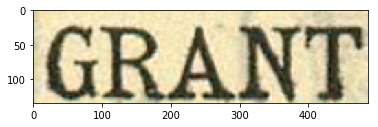

Matched before: GRANT
Matched after:GRAND
Ground truth:GRANT
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


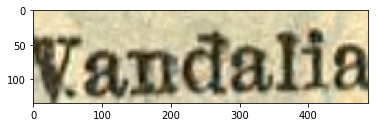

Matched before: Vandalia
Matched after:andalia
Ground truth:Vandalia
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


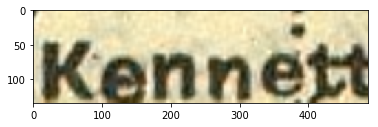

Matched before: Kennett
Matched after:kennet
Ground truth:Kennett
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


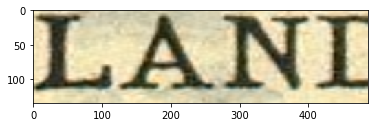

Matched before: LAND
Matched after:LATTE
Ground truth:LAND
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


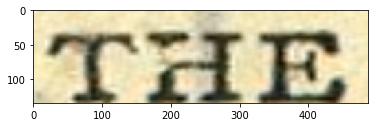

Matched before: THE
Matched after:HE
Ground truth:THE
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


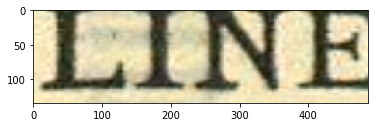

Matched before: LINE
Matched after:LINN
Ground truth:LINE
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


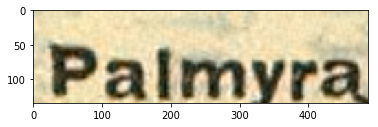

Matched before: Palmyra
Matched after:ap
Ground truth:Palmyra
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


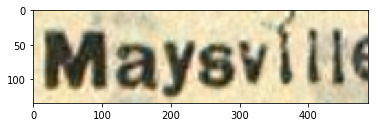

Matched before: Maysville
Matched after:ass
Ground truth:Maysville
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


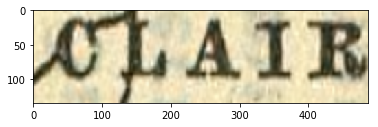

Matched before: CLAIR
Matched after:ADAIR
Ground truth:CLAIR
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


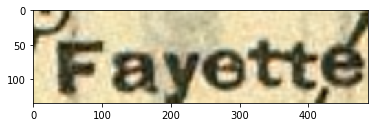

Matched before: Fayette
Matched after:reene
Ground truth:Fayette
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


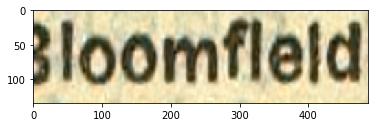

Matched before: Bloomfield
Matched after:Hol
Ground truth:Bloomfield
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


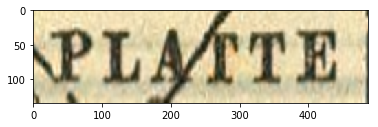

Matched before: PLATTE
Matched after:BATE
Ground truth:PLATTE
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


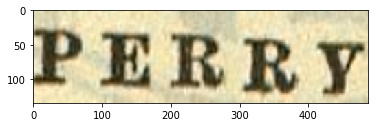

Matched before: PERRY
Matched after:Eminenc
Ground truth:PERRY
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


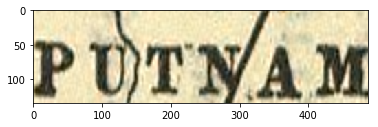

Matched before: PUTNAM
Matched after:ONALD
Ground truth:PUTNAM
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


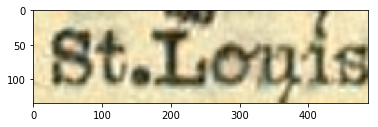

Matched before: St.
Matched after:allas
Ground truth:St.
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


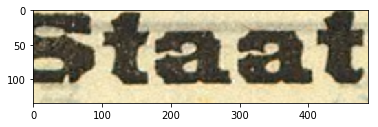

Matched before: Staat
Matched after:nad
Ground truth:Staat
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


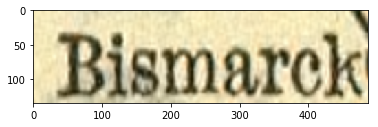

Matched before: Bismarck
Matched after:Bismarc
Ground truth:Bismarck
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


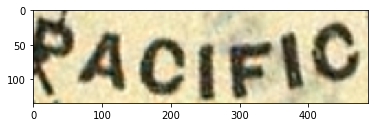

Matched before: PACIFIC
Matched after:ra
Ground truth:PACIFIC
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


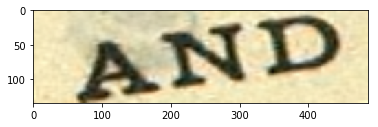

Matched before: AND
Matched after:enry
Ground truth:AND
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


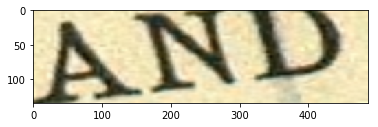

Matched before: AND
Matched after:AY
Ground truth:AND
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


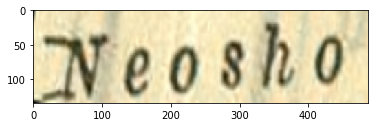

Matched before: Neosho
Matched after:MERCER
Ground truth:Neosho
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


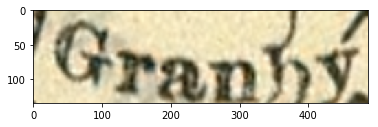

Matched before: Granby
Matched after:Jo.
Ground truth:Granby
Direction extended:0
------------------------------------------------------------------------
------------------------------------------------------------------------


In [20]:
import matplotlib.pyplot as plt
qualified_ids = match_report_before[2]
ground_truth = match_report_before[6]
for i in range(len(qualified_ids)):
    if match_report_before[1][i][0] == ground_truth[i] \
    and match_report_after[1][i][0] != ground_truth[i]:
        print "************************************************************************"
        print "************************************************************************"
        q = np.transpose(images_before[qualified_ids[i]],(1,2,0))
        plt.imshow(q)
        plt.show()
        print "Matched before: "+str(match_report_before[1][i][0])
        print "Matched after:" + str(match_report_after[1][i][0])
        print "Ground truth:" + str(ground_truth[i])
        print "Direction extended:" + str(match_report_before[3][i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
        